<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#toogle-code" data-toc-modified-id="toogle-code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>toogle code</a></span></li><li><span><a href="#DDM" data-toc-modified-id="DDM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DDM</a></span><ul class="toc-item"><li><span><a href="#Concept-Drift" data-toc-modified-id="Concept-Drift-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Concept Drift</a></span><ul class="toc-item"><li><span><a href="#Detect-problematic-instances" data-toc-modified-id="Detect-problematic-instances-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Detect problematic instances</a></span></li><li><span><a href="#Filter-with-normal-SHAP" data-toc-modified-id="Filter-with-normal-SHAP-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Filter with normal SHAP</a></span></li><li><span><a href="#When-DDM-detects-drift-retrain-on-SHAP-batch" data-toc-modified-id="When-DDM-detects-drift-retrain-on-SHAP-batch-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>When DDM detects drift retrain on SHAP batch</a></span></li></ul></li><li><span><a href="#Covariate-Drift" data-toc-modified-id="Covariate-Drift-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Covariate Drift</a></span></li></ul></li><li><span><a href="#No-retraining---do-nothing" data-toc-modified-id="No-retraining---do-nothing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>No retraining - do nothing</a></span><ul class="toc-item"><li><span><a href="#Concept-drift" data-toc-modified-id="Concept-drift-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Concept drift</a></span></li><li><span><a href="#Covariate-drift" data-toc-modified-id="Covariate-drift-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Covariate drift</a></span></li></ul></li><li><span><a href="#Periodically-retrain-without-detecting-drift" data-toc-modified-id="Periodically-retrain-without-detecting-drift-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Periodically retrain without detecting drift</a></span><ul class="toc-item"><li><span><a href="#Concept-drift" data-toc-modified-id="Concept-drift-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Concept drift</a></span></li><li><span><a href="#Covariate-drift" data-toc-modified-id="Covariate-drift-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Covariate drift</a></span></li></ul></li><li><span><a href="#Prior-probability-shift" data-toc-modified-id="Prior-probability-shift-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prior probability shift</a></span></li><li><span><a href="#Compare-Results" data-toc-modified-id="Compare-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare Results</a></span></li><li><span><a href="#TEST" data-toc-modified-id="TEST-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TEST</a></span></li><li><span><a href="#tableau-avec-problemes-de-chaque-type-de-drift" data-toc-modified-id="tableau-avec-problemes-de-chaque-type-de-drift-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>tableau avec problemes de chaque type de drift</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shap

import math

from scipy.stats import ttest_ind

from scipy.io import arff

from lightgbm import LGBMRegressor, LGBMClassifier

import seaborn as sns
import random

from sklearn.metrics import roc_auc_score, f1_score

import matplotlib

2021-10-19 15:15:00.307643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-19 15:15:00.307658: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# toogle code

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
#prepare df with metric to compare different cases

comparison_df = pd.DataFrame(columns = ["mean","sum","f1","roc"])

# DDM

## Concept Drift
--- Circles
__A__: before the drift
__B__: after the drift has occured


$P_A(Y|X)\neq P_B(Y|X)$ and $P_A(X) = P_B(X)$ in $X\rightarrow Y$

$P_A(Y|X)\neq P_B(Y|X)$ and $P_A(X) \neq P_B(X)$ in $X\rightarrow Y$


$P_A(X|Y)\neq P_B(X|Y)$ and $P_A(Y) = P_B(Y)$ in $Y\rightarrow X$

$P_A(X|Y)\neq P_B(X|Y)$ and $P_A(Y) \neq P_B(Y)$ in $Y\rightarrow X$

Concept shit is a change in the relationship between the feature space and the class labels. (Hardest type of shift)

In [4]:
def is_in_circle(x,y, center_x=0.5, center_y = 0.5, r = 0.25):
    return(((x - center_x)**2 + (y - center_y)**2) < r**2)

circles = pd.DataFrame(columns =['x','y','class'])

n_samples = 10**5
n = n_samples
circles['x'] = np.random.rand(n)
circles['y'] = np.random.rand(n)

circle_centers = [0.3,0.45,0.55,0.7]
drift_points = [0, int(n/4), int(2*n/4), int(3*n/4), n]

#all decision circlescircles.loc[int(0*(n/4)):int(1*(n/4)),'class'] =\
circles.loc[int(0*(n/4)):int(1*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[0]), axis=1)
circles.loc[int(1*(n/4)):int(2*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[1]), axis=1)
circles.loc[int(2*(n/4)):int(3*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[2]), axis=1)
circles.loc[int(3*(n/4)):int(4*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[3]), axis=1)
circles.head(5)


x         y  class
0  0.063510  0.677058  False
1  0.963015  0.801302  False
2  0.052638  0.182214  False
3  0.495650  0.858469  False
4  0.993799  0.322923  False

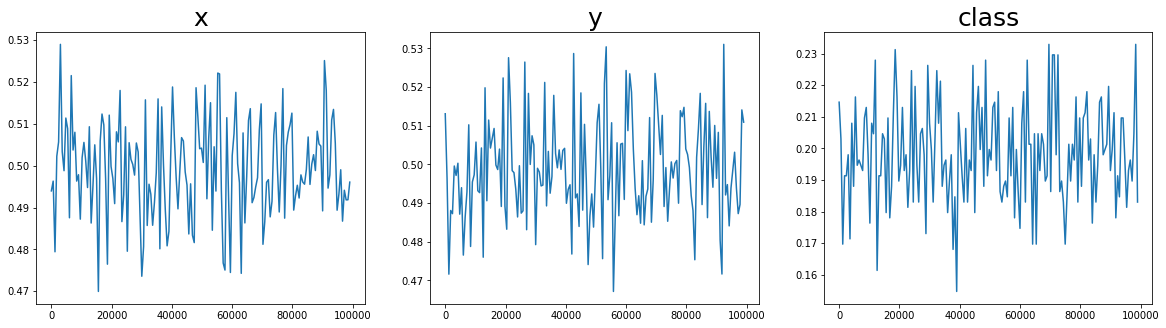

In [5]:
df = circles
fig, ax = plt.subplots(nrows = 1, ncols= 3, figsize =[20,5])
win_size = 600
for k,feat in enumerate(df.columns):
    to_plot = [np.mean(df.loc[i:i+win_size, feat]) for i in range(0,len(df)-win_size,win_size)]
    ax[k].plot(np.arange(0,len(df)-win_size,win_size), to_plot)
    ax[k].set_title(str(feat),fontsize = 25)

In [6]:
#train model 

df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train model
model = LGBMClassifier()
model.fit(X_train, y_train)
print("score :",model.score(X_test, y_test))

score : 0.9958004199580042


 98%|===================| 7879/8001 [00:14<00:00]        

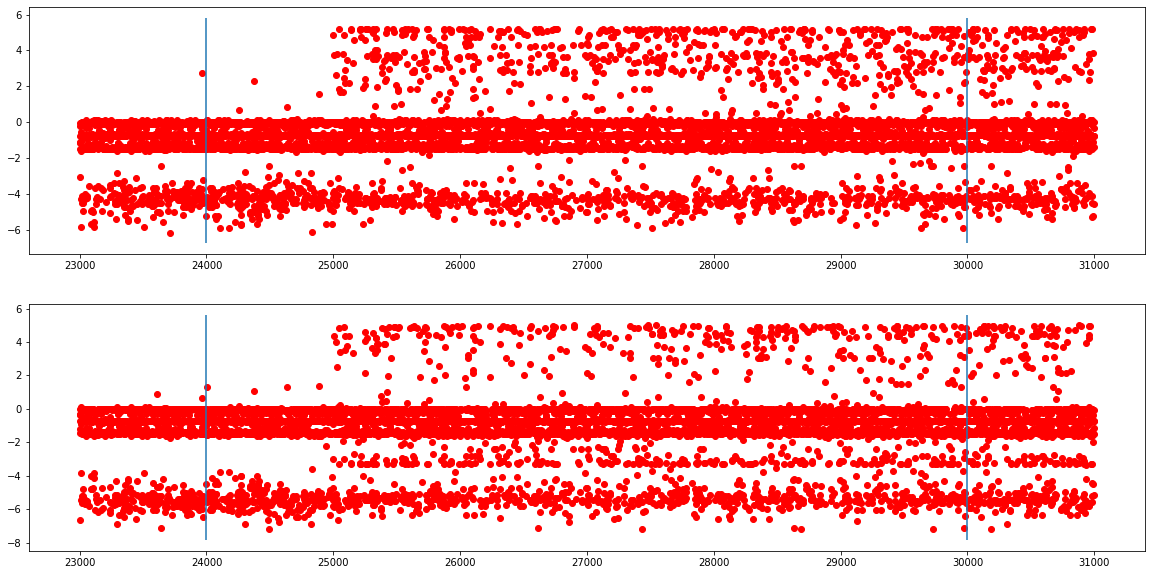

In [7]:
beg,end = 24000, 30000
margin = 1000
#separate data for explanation
X_bgrd = X.loc[n_train+n_test : n_train+n_test+100]

exp_b, exp_e = beg-margin , end+margin
X_explain = X.loc[exp_b : exp_e]
y_explain = y.loc[exp_b : exp_e]

#inspect with SHAP
explainerError = shap.TreeExplainer(model, data = X_bgrd,  
                                    feature_perturbation="interventional", model_output = 'log_loss')
shap_values = explainerError.shap_values(X_explain, y_explain)

#plot
fig, ax =  plt.subplots(nrows = len(X.columns), ncols = 1, figsize = [20,10])
for i,x in enumerate(X.columns):
    ax[i].scatter(np.arange(exp_b, exp_e +1),shap_values[:,i], color = "r")
    ymin, ymax = ax[i].get_ylim()
    ax[i].vlines(x= beg, ymin = ymin, ymax = ymax)
    ax[i].vlines(x= end, ymin = ymin, ymax = ymax)

plt.show()#return(shap_values)

In [8]:
error_measure = [a==b for a,b in zip(model.predict(X_explain), y_explain.values)]

error_test_mean = [np.mean(error_measure[:ix+1]) for ix,value in enumerate(error_measure)]

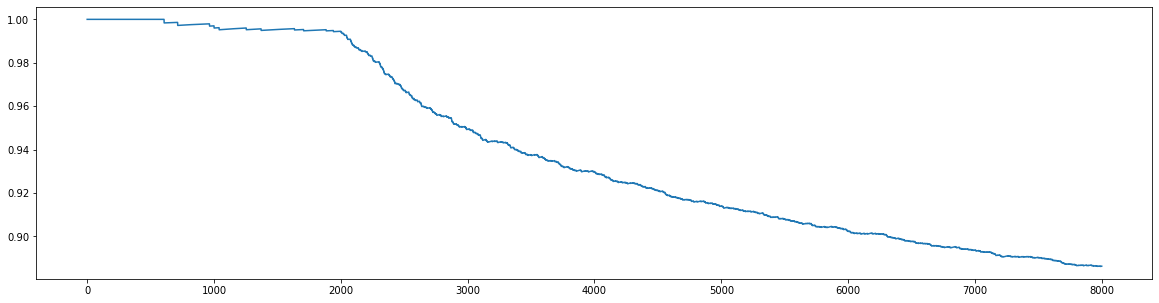

In [12]:
plt.figure(figsize = [20,5])
plt.plot(error_test_mean)

In [13]:
#params = 
w_threshold = 2
d_threshold = 5
n_cold_start = 500

In [14]:
df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []
min_proba_err = 100
min_var_err = 100

#index_first_detection = 0
warning_indices = []
detection_indices = []

first_warning = np.inf


warning_threshold = 1
detection_threshold = 1

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    ##-- detect drift-------------------------------------
    if(i>n_cold_start):#number of cold start
        if((p_err + var_err) < (min_var_err + min_proba_err)):
            min_proba_err = p_err
            min_var_err = var_err

        warning_threshold = min_proba_err + w_threshold * min_var_err
        if((p_err + var_err) > warning_threshold):
            if(count < first_warning):
                first_warning = count
                print("update warning %d"%first_warning)
            warning_indices.append(count)

            
        detection_threshold = min_proba_err + d_threshold * min_var_err
        if((p_err + var_err) > detection_threshold):
            print("DDEETTEECCTTIIOONN",count,"n_retrain : %d"%(count - first_warning))
            detection_indices.append(count)
    
            #train new model
            model = LGBMClassifier()
            #maybe use warning
            #n_samples_retrain = n_cold_start
            n_samples_retrain = count - first_warning#min(n_cold_start, count - first_warning)
            model.fit(X_monitor.iloc[i-n_samples_retrain : i], y_monitor.iloc[i-n_samples_retrain : i])
            #update the data we have not seen yet
            X_monitor, y_monitor = X_monitor.iloc[i:], y_monitor.iloc[i:]
            i = 0
            min_proba_err = 100
            min_var_err = 100
            first_warning = np.inf
            #break

    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

update warning 515
DDEETTEECCTTIIOONN 792 n_retrain : 277
update warning 1937
DDEETTEECCTTIIOONN 5221 n_retrain : 3284
update warning 5884
DDEETTEECCTTIIOONN 6462 n_retrain : 578
10000
20000
update warning 30377
DDEETTEECCTTIIOONN 31499 n_retrain : 1122
10000
20000
update warning 55284
DDEETTEECCTTIIOONN 56152 n_retrain : 868
10000
20000


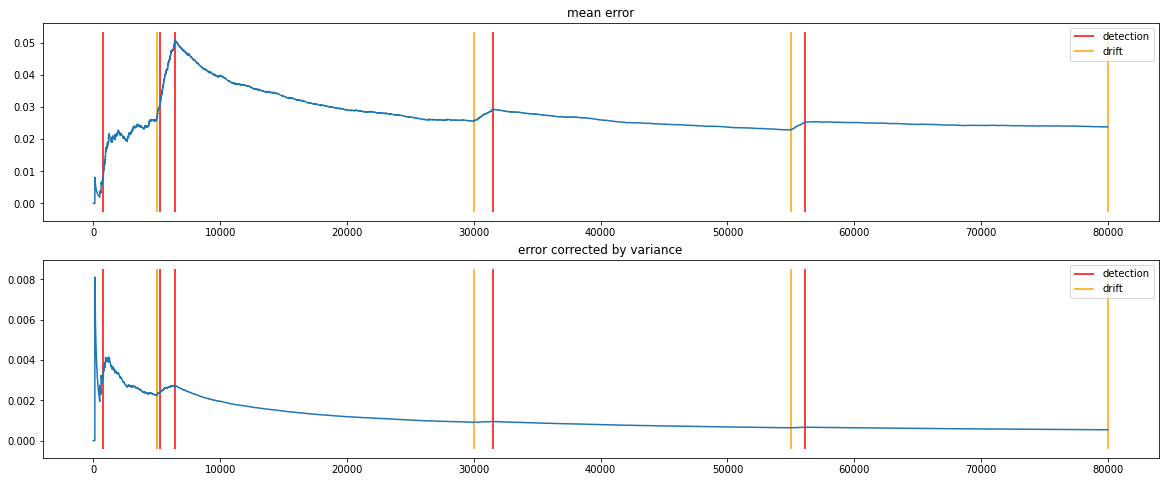

mean: 0.001, sum: 85.875, f1: 0.233, roc: 0.518


In [15]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [20,8])
error_measure_corrected_by_variance =  np.asarray([math.sqrt(val * (1 - val) / (ix +1)) for ix, val in enumerate(error_mean)])

ax[0].plot(error_mean)
ymin,ymax = ax[0].get_ylim()
for detect in detection_indices:
    ax[0].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[0].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[0].set_title("mean error")
    
ax[1].plot(error_measure_corrected_by_variance)
ymin,ymax = ax[1].get_ylim()
for detect in detection_indices:
    ax[1].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[1].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[1].vlines(ymin=ymin, ymax = ymax, x = (n_samples/4) - n_train - n_test,
             color = 'orange', label = 'drift')
ax[1].set_title("error corrected by variance")

#LEGEND
handles, labels = ax[0].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[0].legend(*zip(*unique))
handles, labels = ax[1].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[1].legend(*zip(*unique))

plt.show()

output = [y if x==1 else (y+1)%2 for x,y in zip(errors, df.loc[:,'class'].astype(int))]

roc = roc_auc_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
f1 = f1_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
somme = np.sum(error_measure_corrected_by_variance)
mean = np.mean(error_measure_corrected_by_variance)
print("mean: %.3f, sum: %.3f, f1: %.3f, roc: %.3f"%(mean, somme, f1, roc))
comparison_df.loc['DDM-Concept_drift'] = [mean, somme, f1, roc]

### Detect problematic instances


100%|===================| 7996/8001 [00:14<00:00]        

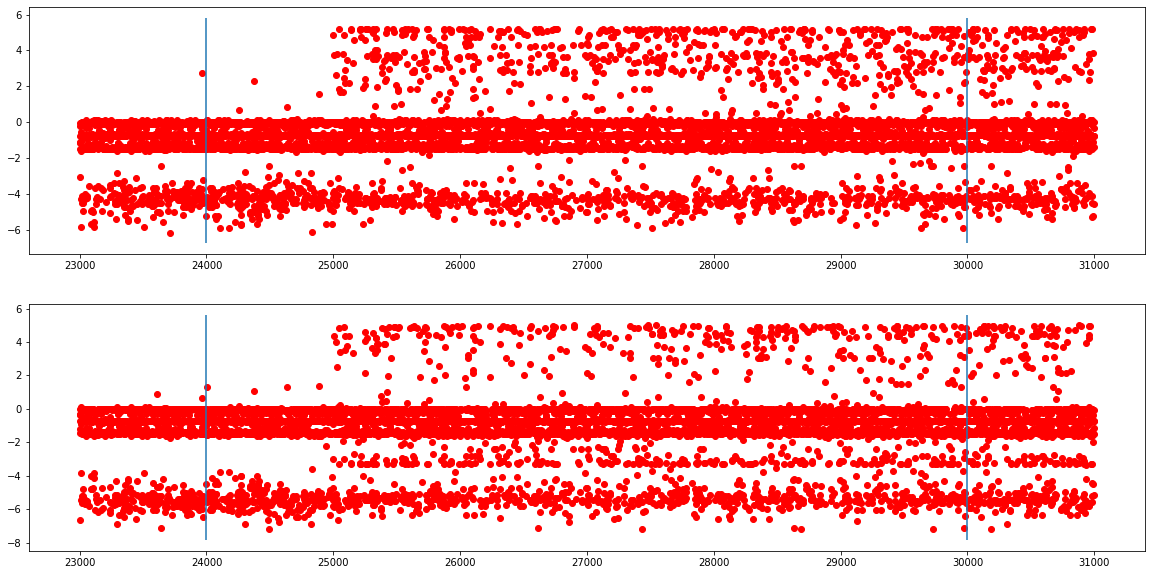

In [16]:
df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)

beg,end = 24000, 30000
margin = 1000
#separate data for explanation
X_bgrd = X.loc[n_train+n_test : n_train+n_test+100]

exp_b, exp_e = beg-margin , end+margin
X_explain = X.loc[exp_b : exp_e]
y_explain = y.loc[exp_b : exp_e]

#inspect with SHAP
explainerError = shap.TreeExplainer(model, data = X_bgrd,  
                                    feature_perturbation="interventional", model_output = 'log_loss')
shap_values = explainerError.shap_values(X_explain, y_explain)

#plot
fig, ax =  plt.subplots(nrows = len(X.columns), ncols = 1, figsize = [20,10])
for i,x in enumerate(X.columns):
    ax[i].scatter(np.arange(exp_b, exp_e +1),shap_values[:,i], color = "r")
    ymin, ymax = ax[i].get_ylim()
    ax[i].vlines(x= beg, ymin = ymin, ymax = ymax)
    ax[i].vlines(x= end, ymin = ymin, ymax = ymax)

plt.show()#return(shap_values)

In [17]:
shap_thresh = np.quantile(shap_values,0.95)
pbm_x = [X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
pbm_y = [X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

print("Shap threshold : %.2f"%shap_thresh)
print("%d problems attributed to X ,\n%d problems attributed to Y"%(len(pbm_x),len(pbm_y)))

Shap threshold : 3.37
496 problems attributed to X ,
305 problems attributed to Y


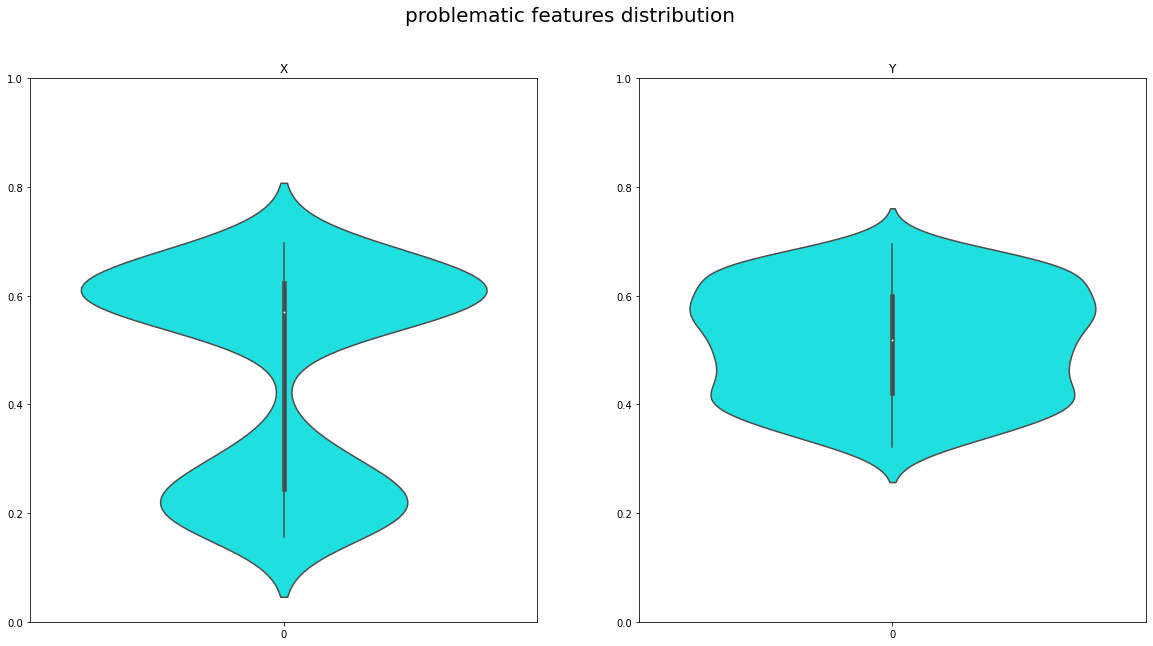

In [18]:
fig, ax = plt.subplots(nrows =1, ncols = 2,figsize = [20,10])
plt.suptitle("problematic features distribution", fontsize = 20)
sns.violinplot(data = pbm_x, ax = ax[0], color= 'cyan')
sns.violinplot(data = pbm_y, ax = ax[1], color= 'cyan')

ax[0].set_ylim(ymin=0,ymax=1)
ax[0].set_title("X")
ax[1].set_ylim(ymin=0,ymax=1)
ax[1].set_title("Y")
plt.show()


In [19]:
circle_centers

[0.3, 0.45, 0.55, 0.7]

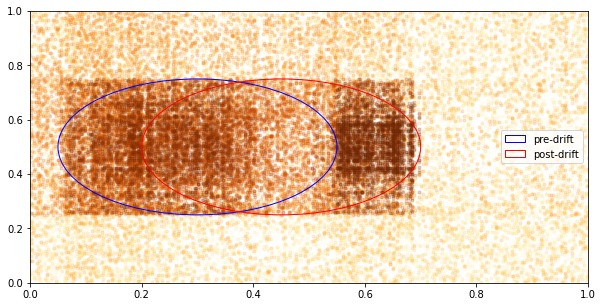

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10,5])

cmap = matplotlib.cm.get_cmap('YlOrBr')#

for t in np.arange(0,1,0.025):#[0.1, 0.5, 0.75, 0.9, 0.99]:
#high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_x = [X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_y = [X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    
    n_new = 1000
    new_gen_x, new_gen_y = np.random.choice(pbm_x, n_new), np.random.choice(pbm_y, n_new)
    ax.scatter(new_gen_x, new_gen_y, marker = '.', alpha = 0.2, color = cmap(t))
    

ax.set_ylim(ymin = 0, ymax=1)
ax.set_xlim(xmin = 0, xmax=1)

#add decision frontier
circle1 = plt.Circle((0.3,0.5),0.25, color = 'b', fill = False, label="pre-drift")
circle2 = plt.Circle((0.45,0.5),0.25, color = 'r', fill = False, label="post-drift")
ax.add_patch(circle1)
ax.add_patch(circle2)
plt.legend()
plt.show()

In [21]:
#Create a newtraining datasetbiasedwith important data 
new_train_x = []
new_train_y = []

for t in [0.1, 0.5, 0.75, 0.9, 0.95]:#np.arange(0,1,0.01)
    #high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_x = [X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_y = [X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    n_new = 100
    new_train_x.append(np.random.choice(pbm_x, n_new))
    new_train_y.append(np.random.choice(pbm_y, n_new))
    #new_gen_x, new_gen_y = , np.random.choice(pbm_y, n_new)
    #ax.scatter(new_gen_x, new_gen_y, marker = '.', alpha = 0.2, color = cmap(t))
new_train_x = np.array(new_train_x).ravel()
new_train_y = np.array(new_train_y).ravel()

In [22]:
#compute biased re-training dataset
new_train = pd.DataFrame(columns = ["x","y","class"])

n_new=200
new_train.loc[:,'x'] = [item for sublist in [np.random.choice([X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if
           x > np.quantile(shap_values, t)],n_new) for t in [0.1, 0.5, 0.75, 0.9, 0.95]]for item in sublist]
new_train.loc[:,'y'] = [item for sublist in [np.random.choice([X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if
           x > np.quantile(shap_values, t)],n_new) for t in [0.1, 0.5, 0.75, 0.9, 0.95]]for item in sublist]

new_train.loc[:,'class'] = new_train.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[1]), axis=1)

X_retrain, y_retrain = new_train.drop(columns=['class']), new_train.loc[:,'class'].astype(bool)

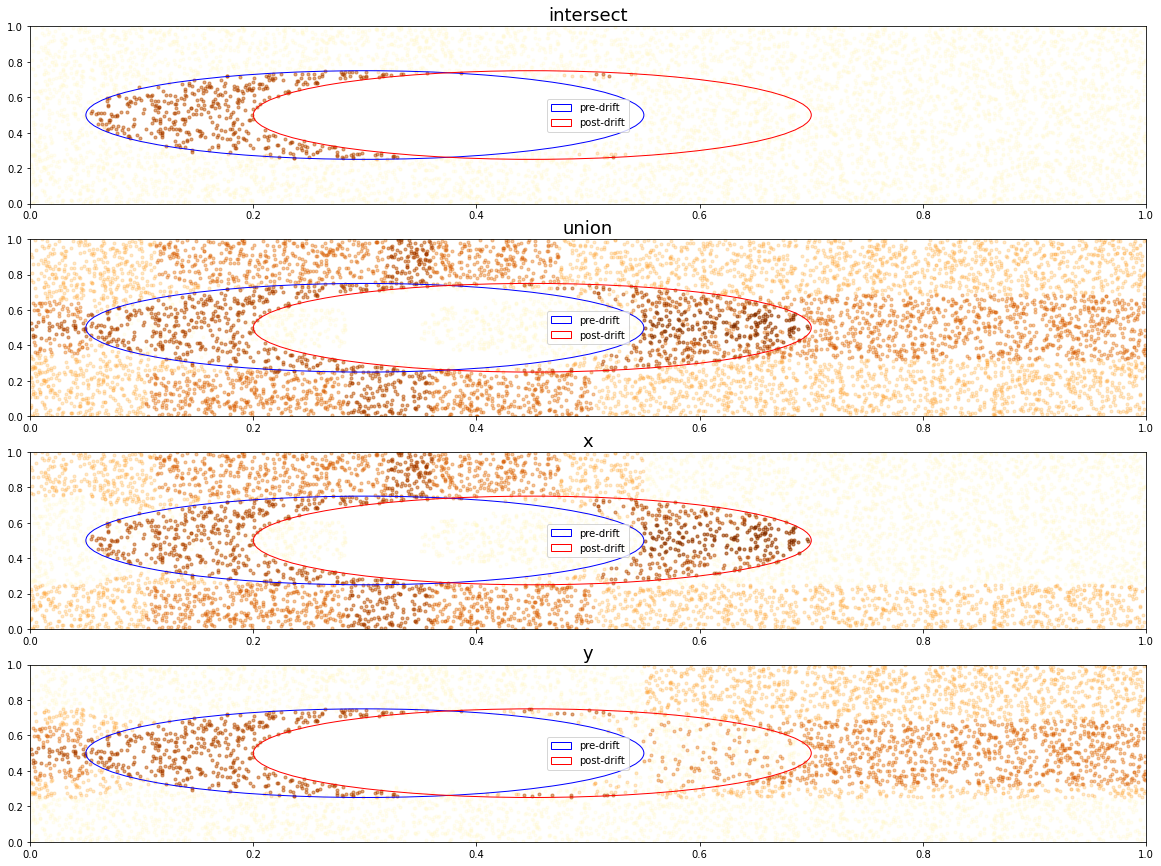

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = [20,15])

cmap = matplotlib.cm.get_cmap('YlOrBr')#

for t in [0.1, 0.5, 0.75, 0.9, 0.99]:
#high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_ix = [i for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_iy = [i for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    pbms_i = np.intersect1d(pbm_ix,pbm_iy)
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[0].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[0].set_title("intersect", fontsize = 18)
    pbms_i = np.union1d(pbm_ix,pbm_iy)
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[1].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[1].set_title("union", fontsize = 18)
    pbms_i = pbm_ix
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[2].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[2].set_title("x", fontsize = 18)
    pbms_i = pbm_iy
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[3].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[3].set_title("y", fontsize = 18)

for i in range(4):
    ax[i].set_ylim(ymin = 0, ymax=1)
    ax[i].set_xlim(xmin = 0, xmax=1)
    circle1 = plt.Circle((0.3,0.5),0.25, color = 'b', fill = False, label="pre-drift")
    circle2 = plt.Circle((0.45,0.5),0.25, color = 'r', fill = False, label="post-drift")
    ax[i].add_patch(circle1)
    ax[i].add_patch(circle2)
    ax[i].legend()
    
plt.show()

### Filter with normal SHAP

group point w.r.t shap relevancy


In [24]:
#compute biased re-training dataset
new_train = pd.DataFrame(columns = ["x","y","class"])
thresholds = [0.95]
n_new=200
new_train.loc[:,'x'] = [item for sublist in [np.random.choice([X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if
           x > np.quantile(shap_values, t)],n_new) for t in thresholds]for item in sublist]
new_train.loc[:,'y'] = [item for sublist in [np.random.choice([X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if
           x > np.quantile(shap_values, t)],n_new) for t in thresholds]for item in sublist]

new_train.loc[:,'class'] = new_train.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[1]), axis=1)
 
X_retrain, y_retrain = new_train.drop(columns=['class']), new_train.loc[:,'class'].astype(bool)

In [25]:
shap.initjs()

In [26]:
explainer = shap.TreeExplainer(model)
shap_val_out = explainer.shap_values(X_retrain)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

In [28]:
for t in [0.95]:#[0.1, 0.5, 0.75, 0.9, 0.99]:
#high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_ix = [i for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_iy = [i for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    pbms_i = pbm_iy
    #pbms_i = np.intersect1d(pbm_ix,pbm_iy)
    #pbms_i = pbm_ix
    #pbms_i = np.union1d(pbm_ix,pbm_iy)
    
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    
    new_train = pd.DataFrame(columns = ["x","y","class"])
    new_train.loc[:,'x'] = pbms_x
    new_train.loc[:,'y'] = pbms_y

    
    explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
    shap_val_out = explainer.shap_values(new_train.drop(columns = ['class']))

#shap.force_plot(explainer.expected_value[0], shap_val_out[0])

In [29]:
print("union")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

union


In [30]:
print("X")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

X


In [31]:
print("Y")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

Y


In [32]:
print("intersect")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

intersect


### When DDM detects drift retrain on SHAP batch

Shap batch is obtained computing last 1000 shapley values and detecting the samples that are causing the most trouble. The new training dataset is a biased data overfed with the instances that were problematic

In [33]:
df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []
min_proba_err = 100
min_var_err = 100

#index_first_detection = 0
warning_indices = []
detection_indices = []

first_warning = np.inf


warning_threshold = 1
detection_threshold = 1

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    ##-- detect drift-------------------------------------
    if(i>n_cold_start):#number of cold start
        if((p_err + var_err) < (min_var_err + min_proba_err)):
            min_proba_err = p_err
            min_var_err = var_err

        warning_threshold = min_proba_err + w_threshold * min_var_err
        if((p_err + var_err) > warning_threshold):
            if(count < first_warning):
                first_warning = count
                print("update warning %d"%first_warning)
            warning_indices.append(count)

            
        detection_threshold = min_proba_err + d_threshold * min_var_err
        if((p_err + var_err) > detection_threshold):
            print("DDEETTEECCTTIIOONN",count,"n_retrain : %d"%(count - first_warning))
            detection_indices.append(count)
    
            #train new model
            model = LGBMClassifier()
            #maybe use warning
            #n_samples_retrain = n_cold_start
            n_samples_retrain = count - first_warning#min(n_cold_start, count - first_warning)
            model.fit(X_monitor.iloc[i-n_samples_retrain : i], y_monitor.iloc[i-n_samples_retrain : i])
            #update the data we have not seen yet
            X_monitor, y_monitor = X_monitor.iloc[i:], y_monitor.iloc[i:]
            i = 0
            min_proba_err = 100
            min_var_err = 100
            first_warning = np.inf
            #break

    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

update warning 515
DDEETTEECCTTIIOONN 792 n_retrain : 277
update warning 1937
DDEETTEECCTTIIOONN 5221 n_retrain : 3284
update warning 5884
DDEETTEECCTTIIOONN 6462 n_retrain : 578
10000
20000
update warning 30377
DDEETTEECCTTIIOONN 31499 n_retrain : 1122
10000
20000
update warning 55284
DDEETTEECCTTIIOONN 56152 n_retrain : 868
10000
20000


## Covariate Drift 
New unseen data


$P_A(Y|X) = P_B(Y|X)$ and $P_A(X) \neq P_B(X)$

only in $Y \rightarrow X$ problems

Covariate shift refers to changes in the feature space alone

In [34]:
circles_cov = pd.DataFrame(columns =['x','y','class'])

n_samples = 10**5
n = n_samples
circles_cov.loc[:,'x'] = np.random.rand(n)
circles_cov.loc[0*int(n/4):1*int(n/4),'y'] = np.random.rand(int(n/4)+1)/4 + 0/4
circles_cov.loc[1*int(n/4):2*int(n/4),'y'] = np.random.rand(int(n/4)+1)/4 + 1/4
circles_cov.loc[2*int(n/4):3*int(n/4),'y'] = np.random.rand(int(n/4)+1)/4 + 2/4
circles_cov.loc[3*int(n/4):4*int(n/4),'y'] = np.random.rand(int(n/4))/4 + 3/4

circles_cov.loc[:,'y'] = circles_cov.loc[:,'y'].astype(np.float64)
#all decision circlescircles.loc[int(0*(n/4)):int(1*(n/4)),'class'] =\
circles_cov.loc[:,"class"] =\
    circles_cov.apply(lambda df: is_in_circle(df.x,df.y,0.3), axis=1)
circles_cov.head(5)

x         y  class
0  0.193213  0.042044  False
1  0.051923  0.063663  False
2  0.244363  0.115824  False
3  0.252384  0.140615  False
4  0.524473  0.074197  False

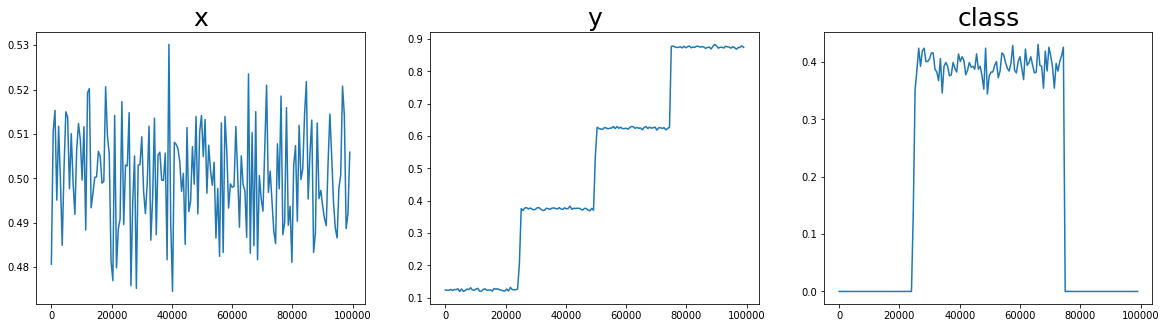

In [35]:
df = circles_cov
fig, ax = plt.subplots(nrows = 1, ncols= 3, figsize =[20,5])
win_size = 600
for k,feat in enumerate(df.columns):
    to_plot = [np.mean(df.loc[i:i+win_size, feat]) for i in range(0,len(df)-win_size,win_size)]
    ax[k].plot(np.arange(0,len(df)-win_size,win_size), to_plot)
    ax[k].set_title(str(feat),fontsize = 25)

In [36]:
#train model 
df = circles_cov.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train model
model = LGBMClassifier()
model.fit(X_train, y_train)
print("score :",model.score(X_test, y_test))

score : 1.0


In [37]:
error_measure = [a==b for a,b in zip(model.predict(X_explain), y_explain.values)]

error_test_mean = [np.mean(error_measure[:ix+1]) for ix,value in enumerate(error_measure)]

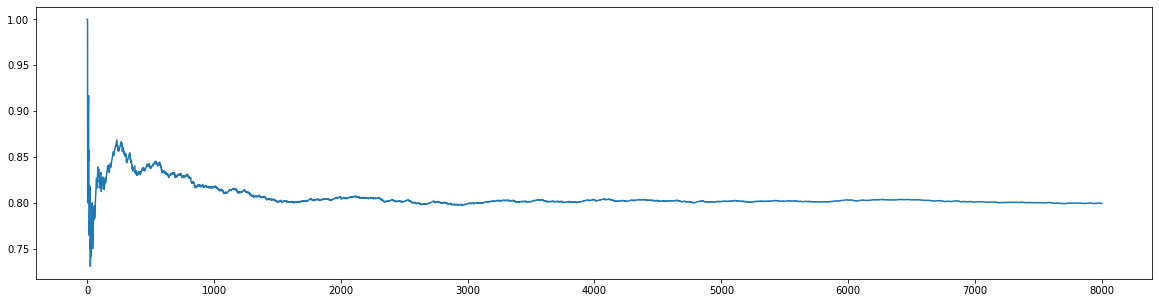

In [38]:
plt.figure(figsize = [20,5])
plt.plot(error_test_mean)

In [39]:
#params = 
w_threshold = 2
d_threshold = 5
n_cold_start = 500

In [40]:
df = circles_cov.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []
min_proba_err = 100
min_var_err = 100

#index_first_detection = 0
warning_indices = []
detection_indices = []

first_warning = np.inf


warning_threshold = 1
detection_threshold = 1

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    ##-- detect drift-------------------------------------
    if(i>n_cold_start):#number of cold start
        if((p_err + var_err) < (min_var_err + min_proba_err)):
            min_proba_err = p_err
            min_var_err = var_err

        warning_threshold = min_proba_err + w_threshold * min_var_err
        if((p_err + var_err) > warning_threshold):
            if(count < first_warning):
                first_warning = count
                print("update warning %d"%first_warning)
            warning_indices.append(count)

            
        detection_threshold = min_proba_err + d_threshold * min_var_err
        if((p_err + var_err) > detection_threshold):
            print("DDEETTEECCTTIIOONN",count,"n_retrain : %d"%(count - first_warning))
            detection_indices.append(count)
    
            #train new model
            model = LGBMClassifier()
            #maybe use warning
            #n_samples_retrain = n_cold_start
            n_samples_retrain = max(n_cold_start, count - first_warning)
            model.fit(X_monitor.iloc[i-n_samples_retrain : i], y_monitor.iloc[i-n_samples_retrain : i])
            #update the data we have not seen yet
            X_monitor, y_monitor = X_monitor.iloc[i:], y_monitor.iloc[i:]
            i = 0
            min_proba_err = 100
            min_var_err = 100
            first_warning = np.inf
            #break

    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

update warning 5001
DDEETTEECCTTIIOONN 5001 n_retrain : 0
update warning 5562
DDEETTEECCTTIIOONN 5675 n_retrain : 113
10000
20000
update warning 30460
DDEETTEECCTTIIOONN 31325 n_retrain : 865
10000
20000
update warning 55182
DDEETTEECCTTIIOONN 55900 n_retrain : 718
10000
20000


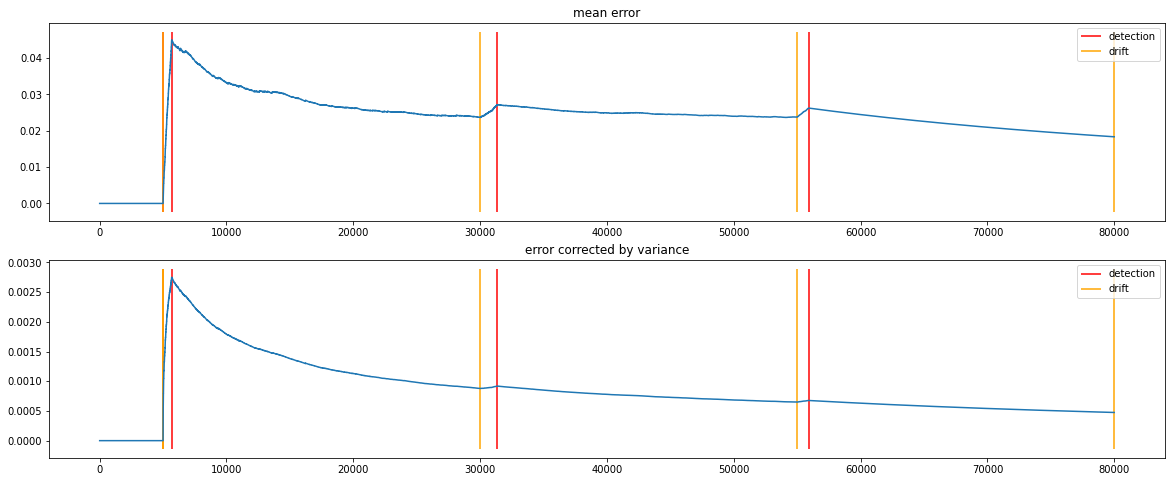

mean: 0.001, sum: 68.042, f1: 0.257, roc: 0.504


In [41]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [20,8])
error_measure_corrected_by_variance =  np.asarray([math.sqrt(val * (1 - val) / (ix +1)) for ix, val in enumerate(error_mean)])

ax[0].plot(error_mean)
ymin,ymax = ax[0].get_ylim()
for detect in detection_indices:
    ax[0].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[0].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[0].set_title("mean error")
    
ax[1].plot(error_measure_corrected_by_variance)
ymin,ymax = ax[1].get_ylim()
for detect in detection_indices:
    ax[1].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[1].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[1].vlines(ymin=ymin, ymax = ymax, x = (n_samples/4) - n_train - n_test,
             color = 'orange', label = 'drift')
ax[1].set_title("error corrected by variance")

#LEGEND
handles, labels = ax[0].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[0].legend(*zip(*unique))
handles, labels = ax[1].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[1].legend(*zip(*unique))

plt.show()

output = [y if x==1 else (y+1)%2 for x,y in zip(errors, df.loc[:,'class'].astype(int))]

roc = roc_auc_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
f1 = f1_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
somme = np.sum(error_measure_corrected_by_variance)
mean = np.mean(error_measure_corrected_by_variance)
print("mean: %.3f, sum: %.3f, f1: %.3f, roc: %.3f"%(mean, somme, f1, roc))
comparison_df.loc['DDM-Covariate_drift'] = [mean, somme, f1, roc]

# No retraining - do nothing

## Concept drift

In [42]:
df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    
    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

10000
20000
30000
40000
50000
60000
70000
80000


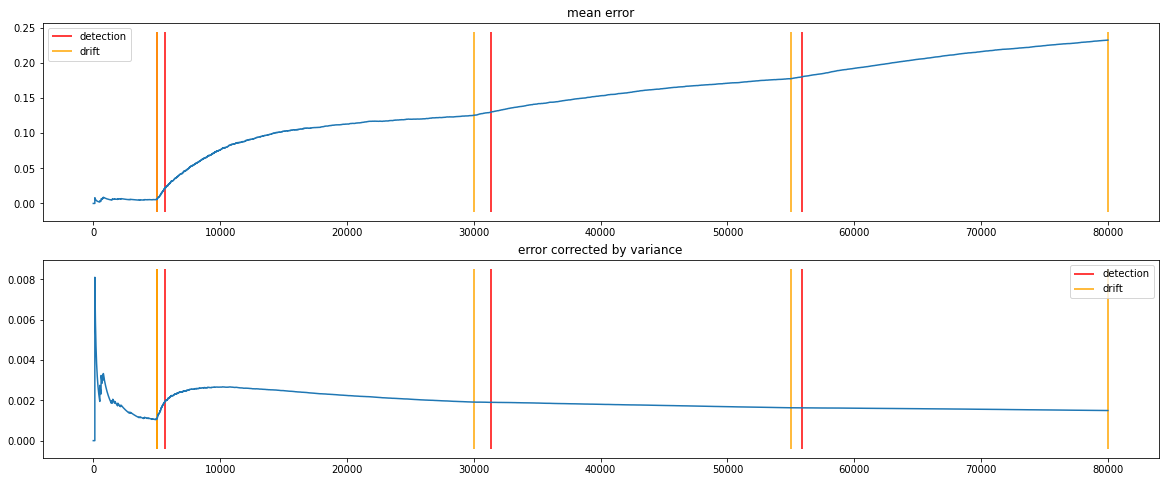

mean: 0.002, sum: 149.224, f1: 0.409, roc: 0.634


In [43]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [20,8])
error_measure_corrected_by_variance =  np.asarray([math.sqrt(val * (1 - val) / (ix +1)) for ix, val in enumerate(error_mean)])

ax[0].plot(error_mean)
ymin,ymax = ax[0].get_ylim()
for detect in detection_indices:
    ax[0].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[0].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[0].set_title("mean error")
    
ax[1].plot(error_measure_corrected_by_variance)
ymin,ymax = ax[1].get_ylim()
for detect in detection_indices:
    ax[1].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[1].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[1].vlines(ymin=ymin, ymax = ymax, x = (n_samples/4) - n_train - n_test,
             color = 'orange', label = 'drift')
ax[1].set_title("error corrected by variance")

#LEGEND
handles, labels = ax[0].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[0].legend(*zip(*unique))
handles, labels = ax[1].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[1].legend(*zip(*unique))

plt.show()

output = [y if x==1 else (y+1)%2 for x,y in zip(errors, df.loc[:,'class'].astype(int))]

roc = roc_auc_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
f1 = f1_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
somme = np.sum(error_measure_corrected_by_variance)
mean = np.mean(error_measure_corrected_by_variance)
print("mean: %.3f, sum: %.3f, f1: %.3f, roc: %.3f"%(mean, somme, f1, roc))
comparison_df.loc['no_retrain_concept'] = [mean, somme, f1, roc]

## Covariate drift

In [44]:
df = circles_cov.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    
    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

10000
20000
30000
40000
50000
60000
70000
80000


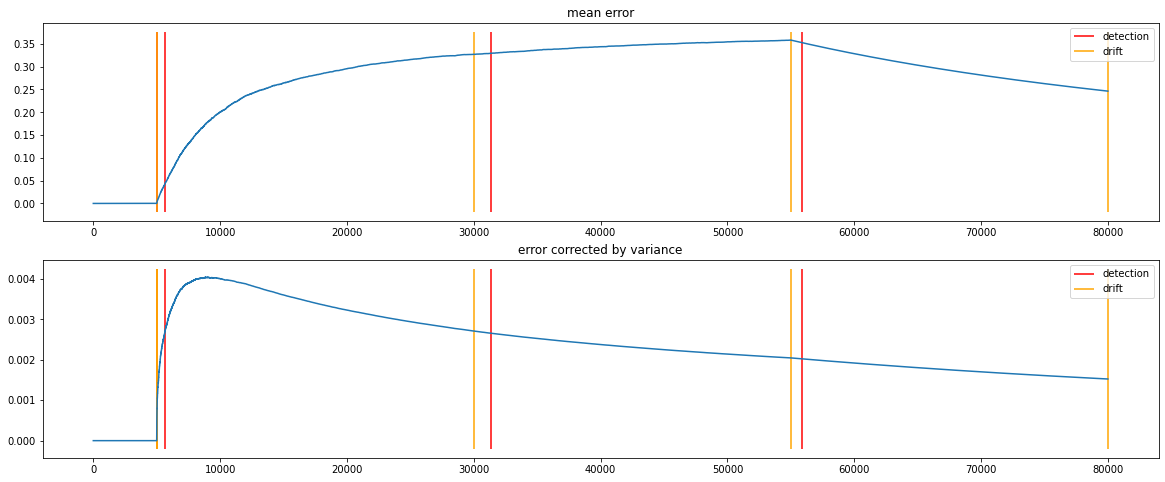

mean: 0.002, sum: 185.613, f1: 0.605, roc: 0.757


In [45]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [20,8])
error_measure_corrected_by_variance =  np.asarray([math.sqrt(val * (1 - val) / (ix +1)) for ix, val in enumerate(error_mean)])

ax[0].plot(error_mean)
ymin,ymax = ax[0].get_ylim()
for detect in detection_indices:
    ax[0].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[0].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[0].set_title("mean error")
    
ax[1].plot(error_measure_corrected_by_variance)
ymin,ymax = ax[1].get_ylim()
for detect in detection_indices:
    ax[1].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[1].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[1].vlines(ymin=ymin, ymax = ymax, x = (n_samples/4) - n_train - n_test,
             color = 'orange', label = 'drift')
ax[1].set_title("error corrected by variance")

#LEGEND
handles, labels = ax[0].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[0].legend(*zip(*unique))
handles, labels = ax[1].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[1].legend(*zip(*unique))

plt.show()

output = [y if x==1 else (y+1)%2 for x,y in zip(errors, df.loc[:,'class'].astype(int))]

roc = roc_auc_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
f1 = f1_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
somme = np.sum(error_measure_corrected_by_variance)
mean = np.mean(error_measure_corrected_by_variance)
print("mean: %.3f, sum: %.3f, f1: %.3f, roc: %.3f"%(mean, somme, f1, roc))
comparison_df.loc['no_retrain_covariate'] = [mean, somme, f1, roc]

# Periodically retrain without detecting drift

## Concept drift

In [46]:
df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    if((i+1)%1000 == 0):
        model = LGBMClassifier()
        #maybe use warning
        #n_samples_retrain = n_cold_start
        n_samples_retrain = max(n_cold_start, count - first_warning)
        model.fit(X_monitor.iloc[i-300 : i], y_monitor.iloc[i-300 : i])
        #update the data we have not seen yet
        X_monitor, y_monitor = X_monitor.iloc[i:], y_monitor.iloc[i:]
        i = 0
        
    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

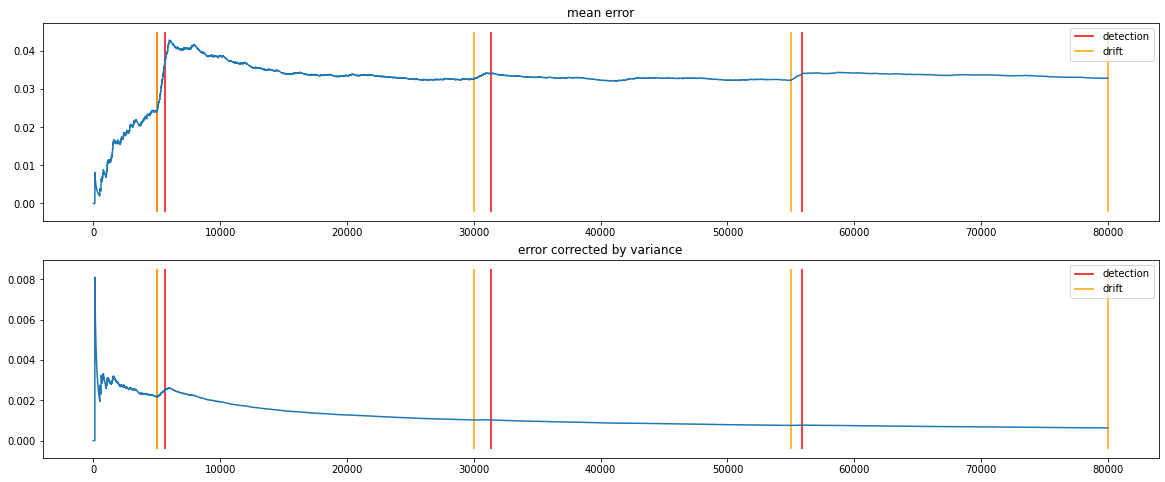

mean: 0.001, sum: 90.339, f1: 0.241, roc: 0.522


In [47]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [20,8])
error_measure_corrected_by_variance =  np.asarray([math.sqrt(val * (1 - val) / (ix +1)) for ix, val in enumerate(error_mean)])

ax[0].plot(error_mean)
ymin,ymax = ax[0].get_ylim()
for detect in detection_indices:
    ax[0].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[0].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[0].set_title("mean error")
    
ax[1].plot(error_measure_corrected_by_variance)
ymin,ymax = ax[1].get_ylim()
for detect in detection_indices:
    ax[1].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[1].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[1].vlines(ymin=ymin, ymax = ymax, x = (n_samples/4) - n_train - n_test,
             color = 'orange', label = 'drift')
ax[1].set_title("error corrected by variance")

#LEGEND
handles, labels = ax[0].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[0].legend(*zip(*unique))
handles, labels = ax[1].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[1].legend(*zip(*unique))

plt.show()

output = [y if x==1 else (y+1)%2 for x,y in zip(errors, df.loc[:,'class'].astype(int))]

roc = roc_auc_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
f1 = f1_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
somme = np.sum(error_measure_corrected_by_variance)
mean = np.mean(error_measure_corrected_by_variance)
print("mean: %.3f, sum: %.3f, f1: %.3f, roc: %.3f"%(mean, somme, f1, roc))
comparison_df.loc['period-retrain_concept'] = [mean, somme, f1, roc]

## Covariate drift

In [48]:
df = circles_cov.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    if((i+1)%1000 == 0):
        model = LGBMClassifier()
        #maybe use warning
        #n_samples_retrain = n_cold_start
        n_samples_retrain = max(n_cold_start, count - first_warning)
        model.fit(X_monitor.iloc[i-300 : i], y_monitor.iloc[i-300 : i])
        #update the data we have not seen yet
        X_monitor, y_monitor = X_monitor.iloc[i:], y_monitor.iloc[i:]
        i = 0
        
    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

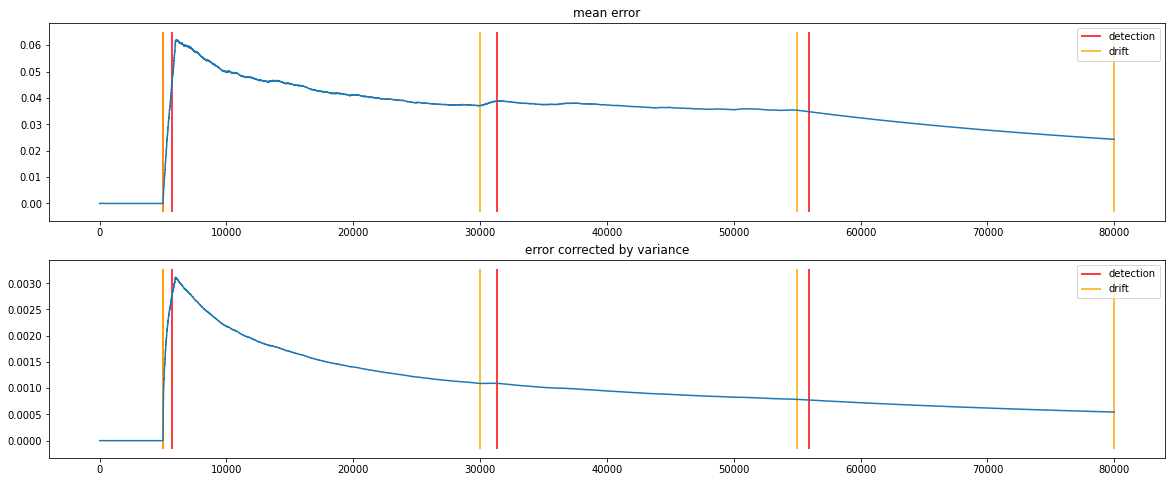

mean: 0.001, sum: 81.550, f1: 0.265, roc: 0.508


In [49]:
fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [20,8])
error_measure_corrected_by_variance =  np.asarray([math.sqrt(val * (1 - val) / (ix +1)) for ix, val in enumerate(error_mean)])

ax[0].plot(error_mean)
ymin,ymax = ax[0].get_ylim()
for detect in detection_indices:
    ax[0].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[0].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[0].set_title("mean error")
    
ax[1].plot(error_measure_corrected_by_variance)
ymin,ymax = ax[1].get_ylim()
for detect in detection_indices:
    ax[1].vlines(ymin=ymin, ymax = ymax, x = detect, color = 'r', label = "detection")
for d in range(1,5):
    ax[1].vlines(ymin=ymin, ymax = ymax, x = (d*n_samples/4) - n_train - n_test,
                 color = 'orange', label = 'drift')
ax[1].vlines(ymin=ymin, ymax = ymax, x = (n_samples/4) - n_train - n_test,
             color = 'orange', label = 'drift')
ax[1].set_title("error corrected by variance")

#LEGEND
handles, labels = ax[0].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[0].legend(*zip(*unique))
handles, labels = ax[1].get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax[1].legend(*zip(*unique))

plt.show()

output = [y if x==1 else (y+1)%2 for x,y in zip(errors, df.loc[:,'class'].astype(int))]

roc = roc_auc_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
f1 = f1_score(df.loc[n_train+n_test:,'class'].astype(int).values, output)
somme = np.sum(error_measure_corrected_by_variance)
mean = np.mean(error_measure_corrected_by_variance)
print("mean: %.3f, sum: %.3f, f1: %.3f, roc: %.3f"%(mean, somme, f1, roc))
comparison_df.loc['period-retrain_covariate'] = [mean, somme, f1, roc]

# Prior probability shift

$P_A(X|Y) = P_B(X|Y)$ and $P_A(Y) \neq P_B(Y)$

only in $X \rightarrow Y$ problems

Prior probability shift refers to changes in the class proportions alone.

In [50]:
def is_in_circle(x,y, center_x=0.5, center_y=0.5, r=0.25):
    return(((x - center_x)**2 + (y - center_y)**2) < r**2)

circles_prior = pd.DataFrame(columns =['x','y','class'])

n_samples = 10**4
n = n_samples
circles_prior['x'] = np.random.rand(n)
circles_prior['y'] = np.random.rand(n)
#all decision circlescircles.loc[int(0*(n/4)):int(1*(n/4)),'class'] =\
circles_prior.loc[:,'class'] =\
    circles_prior.apply(lambda df: is_in_circle(x = df.x, y = df.y,
                    center_x = 0.3,center_y = 0.3, r = 0.25), axis=1)
circles_prior.head(5)

x         y  class
0  0.378554  0.849554  False
1  0.859169  0.927097  False
2  0.475621  0.100719  False
3  0.933415  0.012067  False
4  0.730439  0.089201  False

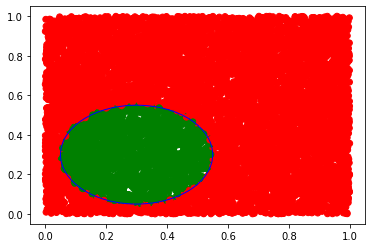

In [51]:
df = circles_prior.copy()
circle1 = plt.Circle((0.3,0.3),0.25, color = 'b', fill = False)
ax = plt.gca()
ax.add_patch(circle1)

color_dict = {False: 'g', True: 'r'}

ax.scatter(x = df.loc[:,'x'],
           y = df.loc[:,'y'], 
           color = ['g' if x else 'r' for x in df.loc[:,"class"]])

    
plt.show()

In [52]:
x_prior = []
y_prior = []
for i in range(int(n/4)):
    a = np.random.rand(1)
    b = np.random.rand(1)
    c = np.random.rand(1)
    d = np.random.rand(1)
    if(a<0.5 and b<0.5):
        if(c>0.5 and d>0.5):
            x_prior.append(a)
            x_prior.append(d)
            y_prior.append(c)
            y_prior.append(b)
        else:
            x_prior.append(a)
            x_prior.append(c)
            y_prior.append(b)
            y_prior.append(d)
    elif(c<0.5 and d<0.5):
        if(a>0.5 and b>0.5):
            x_prior.append(a)
            x_prior.append(d)
            y_prior.append(c)
            y_prior.append(b)
        else:
            x_prior.append(a)
            x_prior.append(c)
            y_prior.append(b)
            y_prior.append(d)
    else:
        x_prior.append(a)
        x_prior.append(c)
        y_prior.append(b)
        y_prior.append(d)
circles_prior.loc[int(n/2):,'x'] = x_prior
circles_prior.loc[int(n/2):,'y'] = y_prior
circles_prior.loc[int(n/2):,'class'] = circles_prior.apply(lambda df: is_in_circle(x = df.x, y = df.y,
                    center_x = 0.3,center_y = 0.3, r = 0.25), axis=1)

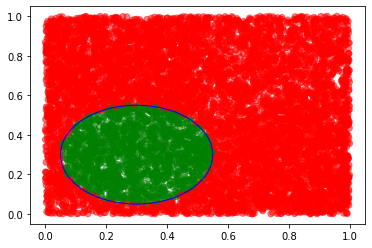

In [53]:
df = circles_prior.copy()
circle1 = plt.Circle((0.3,0.3),0.25, color = 'b', fill = False)
ax = plt.gca()
ax.add_patch(circle1)

color_dict = {False: 'g', True: 'r'}

ax.scatter(x = df.loc[:,'x'],
           y = df.loc[:,'y'], 
           color = ['g' if x else 'r' for x in df.loc[:,"class"]],alpha = 0.5)

    
plt.show()

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


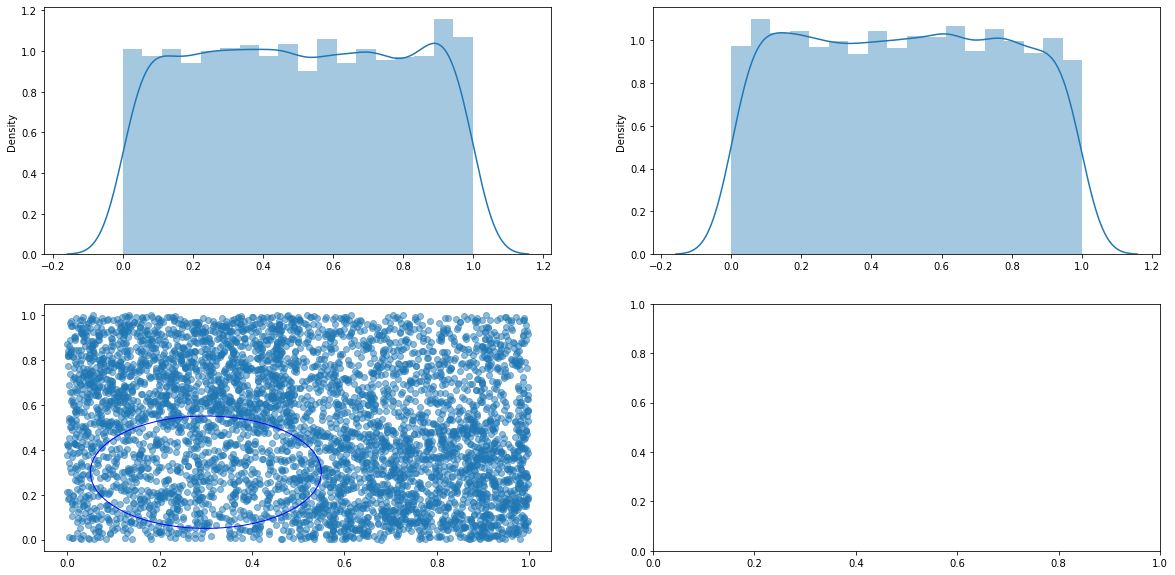

In [54]:
fig, ax = plt.subplots(nrows =2 , ncols=2, figsize = [20,10])
sns.distplot(x_prior,ax=ax[0,0])
sns.distplot(y_prior,ax=ax[0,1])

ax[1,0].scatter(x_prior,y_prior,alpha = 0.5)
circle1 = plt.Circle((0.3,0.3),0.25, color = 'b', fill = False)

ax[1,0].add_patch(circle1)

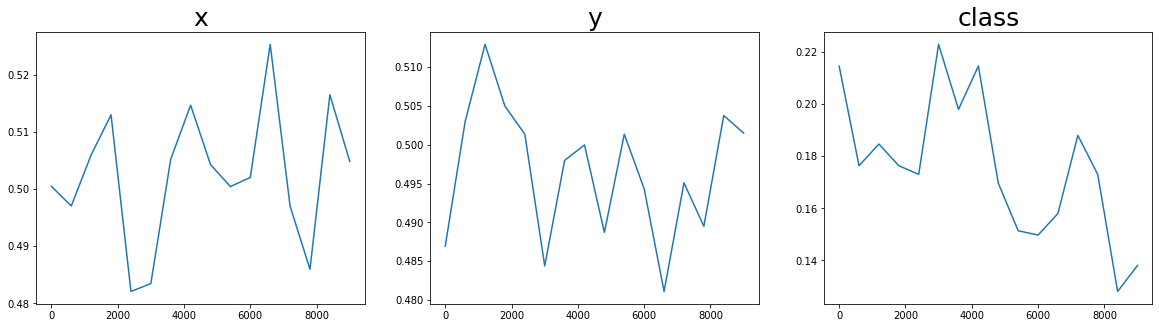

In [55]:
df = circles_prior.copy()
fig, ax = plt.subplots(nrows = 1, ncols= 3, figsize =[20,5])
win_size = 600
for k,feat in enumerate(df.columns):
    to_plot = [np.mean(df.loc[i:i+win_size, feat]) for i in range(0,len(df)-win_size,win_size)]
    ax[k].plot(np.arange(0,len(df)-win_size,win_size), to_plot)
    ax[k].set_title(str(feat),fontsize = 25)

In [56]:
df = circles_prior.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)


X_monitor, y_monitor = X.loc[n_train+n_test:], y.loc[n_train+n_test:]
errors = []
error_mean = []
error_variance = []
min_proba_err = 100
min_var_err = 100

#index_first_detection = 0
warning_indices = []
detection_indices = []

first_warning = np.inf


warning_threshold = 1
detection_threshold = 1

e_count = 0
i = 0
count = 0
while(i<len(X_monitor)):
    #get next sample
    x, label = X_monitor.iloc[i], y_monitor.iloc[i]
    
    #update error and variance metrics ------------------
    error = int(model.predict([x])==label)
    errors.append(error)
    if(error == 0):
        e_count += 1
    count += 1
    p_err = e_count/(count)
    error_mean.append(p_err)
    
    var_err = math.sqrt(p_err * (1 - p_err)/(count))
    error_variance.append(var_err)
    
    ##-- detect drift-------------------------------------
    if(i>n_cold_start):#number of cold start
        if((p_err + var_err) < (min_var_err + min_proba_err)):
            min_proba_err = p_err
            min_var_err = var_err

        warning_threshold = min_proba_err + w_threshold * min_var_err
        if((p_err + var_err) > warning_threshold):
            if(count < first_warning):
                first_warning = count
                print("update warning %d"%first_warning)
            warning_indices.append(count)

            
        detection_threshold = min_proba_err + d_threshold * min_var_err
        if((p_err + var_err) > detection_threshold):
            print("DDEETTEECCTTIIOONN",count,"n_retrain : %d"%(count - first_warning))
            detection_indices.append(count)
    
            #train new model
            model = LGBMClassifier()
            #maybe use warning
            #n_samples_retrain = n_cold_start
            n_samples_retrain = count - first_warning#min(n_cold_start, count - first_warning)
            model.fit(X_monitor.iloc[i-n_samples_retrain : i], y_monitor.iloc[i-n_samples_retrain : i])
            #update the data we have not seen yet
            X_monitor, y_monitor = X_monitor.iloc[i:], y_monitor.iloc[i:]
            i = 0
            min_proba_err = 100
            min_var_err = 100
            first_warning = np.inf
            #break

    i+=1
    if(i%10000 == 0):
        print(i)
        #print(i, "%.3f - %.3f - %.3f"%(warning_threshold, detection_threshold, p_err))

# Compare Results

In [58]:
comparison_df.sort_values('roc')

mean         sum        f1       roc
DDM-Covariate_drift       0.000851   68.042426  0.256710  0.503600
period-retrain_covariate  0.001019   81.550424  0.264698  0.507756
DDM-Concept_drift         0.001073   85.874777  0.233225  0.518337
period-retrain_concept    0.001129   90.339366  0.240697  0.521718
no_retrain_concept        0.001865  149.223865  0.409369  0.634446
no_retrain_covariate      0.002320  185.612504  0.604523  0.757242

In [59]:
comparison_df.sort_values('roc').iloc[1:].style.background_gradient()

# TEST 

In [60]:
def is_in_circle(x,y, center_x=0.5, center_y = 0.5, r = 0.25):
    return(((x - center_x)**2 + (y - center_y)**2) < r**2)

circles = pd.DataFrame(columns =['x','y','class'])

n_samples = 10**5
n = n_samples
circles['x'] = np.random.rand(n)
circles['y'] = np.random.rand(n)

circle_centers = [0.3,0.45,0.55,0.7]
drift_points = [0, int(n/4), int(2*n/4), int(3*n/4), n]

#all decision circlescircles.loc[int(0*(n/4)):int(1*(n/4)),'class'] =\
circles.loc[int(0*(n/4)):int(1*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[0]), axis=1)
circles.loc[int(1*(n/4)):int(2*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[1], 0.7), axis=1)
circles.loc[int(2*(n/4)):int(3*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[2]), axis=1)
circles.loc[int(3*(n/4)):int(4*(n/4)),'class'] =\
    circles.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[3]), axis=1)
circles.head(5)


x         y  class
0  0.989497  0.099522  False
1  0.903119  0.941803  False
2  0.195008  0.821266  False
3  0.319027  0.034605  False
4  0.652611  0.238911  False

In [61]:
#train model 

df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train model
model = LGBMClassifier()
model.fit(X_train, y_train)
print("score :",model.score(X_test, y_test))

score : 0.9939006099390061


 97%|=================== | 7756/8001 [00:15<00:00]       

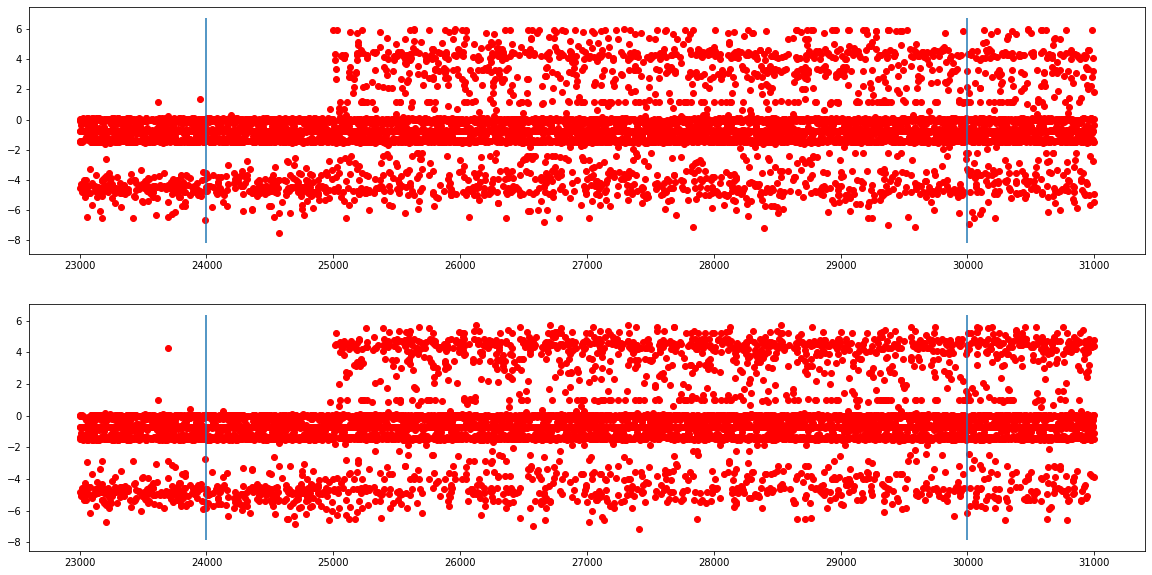

In [62]:
df = circles.copy()

n_train = 10000
n_test = 10000
X, y = df.drop(columns=['class']), df.loc[:,'class'].astype(bool)
X_train, y_train = X.loc[:n_train], y.loc[:n_train]

#X_test, y_test = X.loc[n_train:n_train+n_test], y.loc[n_train:n_train+n_test]

#train initial model
model = LGBMClassifier()
model.fit(X_train, y_train)

beg,end = 24000, 30000
margin = 1000
#separate data for explanation
X_bgrd = X.loc[n_train+n_test : n_train+n_test+100]

exp_b, exp_e = beg-margin , end+margin
X_explain = X.loc[exp_b : exp_e]
y_explain = y.loc[exp_b : exp_e]

#inspect with SHAP
explainerError = shap.TreeExplainer(model, data = X_bgrd,  
                                    feature_perturbation="interventional", model_output = 'log_loss')
shap_values = explainerError.shap_values(X_explain, y_explain)

#plot
fig, ax =  plt.subplots(nrows = len(X.columns), ncols = 1, figsize = [20,10])
for i,x in enumerate(X.columns):
    ax[i].scatter(np.arange(exp_b, exp_e +1),shap_values[:,i], color = "r")
    ymin, ymax = ax[i].get_ylim()
    ax[i].vlines(x= beg, ymin = ymin, ymax = ymax)
    ax[i].vlines(x= end, ymin = ymin, ymax = ymax)

plt.show()#return(shap_values)

In [63]:
#Create a newtraining datasetbiasedwith important data 
new_train_x = []
new_train_y = []

for t in [0.1, 0.5, 0.75, 0.9, 0.95]:#np.arange(0,1,0.01)
    #high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_x = [X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_y = [X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    n_new = 100
    new_train_x.append(np.random.choice(pbm_x, n_new))
    new_train_y.append(np.random.choice(pbm_y, n_new))
    #new_gen_x, new_gen_y = , np.random.choice(pbm_y, n_new)
    #ax.scatter(new_gen_x, new_gen_y, marker = '.', alpha = 0.2, color = cmap(t))
new_train_x = np.array(new_train_x).ravel()
new_train_y = np.array(new_train_y).ravel()

In [64]:
#compute biased re-training dataset
new_train = pd.DataFrame(columns = ["x","y","class"])

n_new=200
new_train.loc[:,'x'] = [item for sublist in [np.random.choice([X_explain.iloc[i,0] for i,x in enumerate(shap_values[:,0]) if
           x > np.quantile(shap_values, t)],n_new) for t in [0.1, 0.5, 0.75, 0.9, 0.95]]for item in sublist]
new_train.loc[:,'y'] = [item for sublist in [np.random.choice([X_explain.iloc[i,1] for i,x in enumerate(shap_values[:,1]) if
           x > np.quantile(shap_values, t)],n_new) for t in [0.1, 0.5, 0.75, 0.9, 0.95]]for item in sublist]

new_train.loc[:,'class'] = new_train.apply(lambda df: is_in_circle(df.x,df.y, circle_centers[1]), axis=1)

X_retrain, y_retrain = new_train.drop(columns=['class']), new_train.loc[:,'class'].astype(bool)

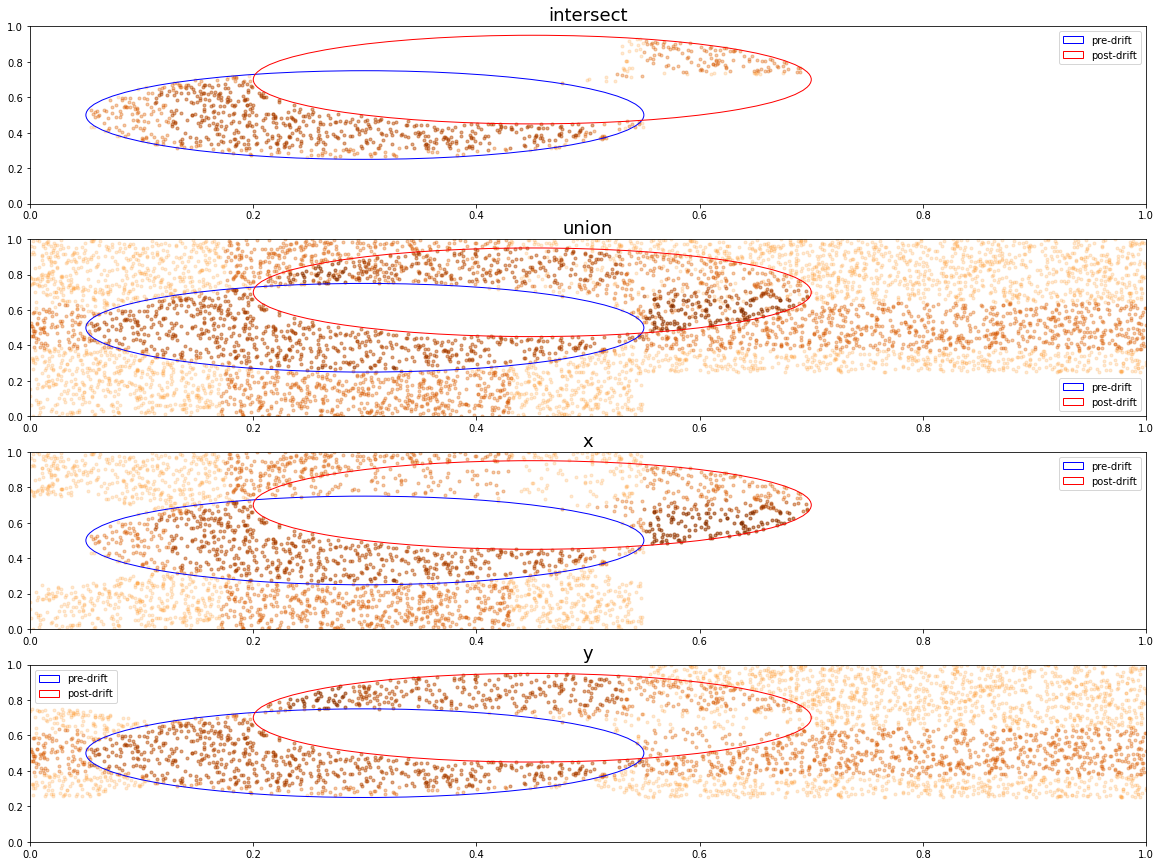

In [65]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = [20,15])

cmap = matplotlib.cm.get_cmap('YlOrBr')#

for t in [0.5, 0.75, 0.9, 0.99]:
#high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_ix = [i for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_iy = [i for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    pbms_i = np.intersect1d(pbm_ix,pbm_iy)
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[0].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[0].set_title("intersect", fontsize = 18)
    pbms_i = np.union1d(pbm_ix,pbm_iy)
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[1].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[1].set_title("union", fontsize = 18)
    pbms_i = pbm_ix
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[2].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[2].set_title("x", fontsize = 18)
    pbms_i = pbm_iy
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax[3].scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax[3].set_title("y", fontsize = 18)

for i in range(4):
    ax[i].set_ylim(ymin = 0, ymax=1)
    ax[i].set_xlim(xmin = 0, xmax=1)
    circle1 = plt.Circle((0.3,0.5),0.25, color = 'b', fill = False, label="pre-drift")
    circle2 = plt.Circle((0.45,0.7),0.25, color = 'r', fill = False, label="post-drift")
    ax[i].add_patch(circle1)
    ax[i].add_patch(circle2)
    ax[i].legend()
    
plt.show()

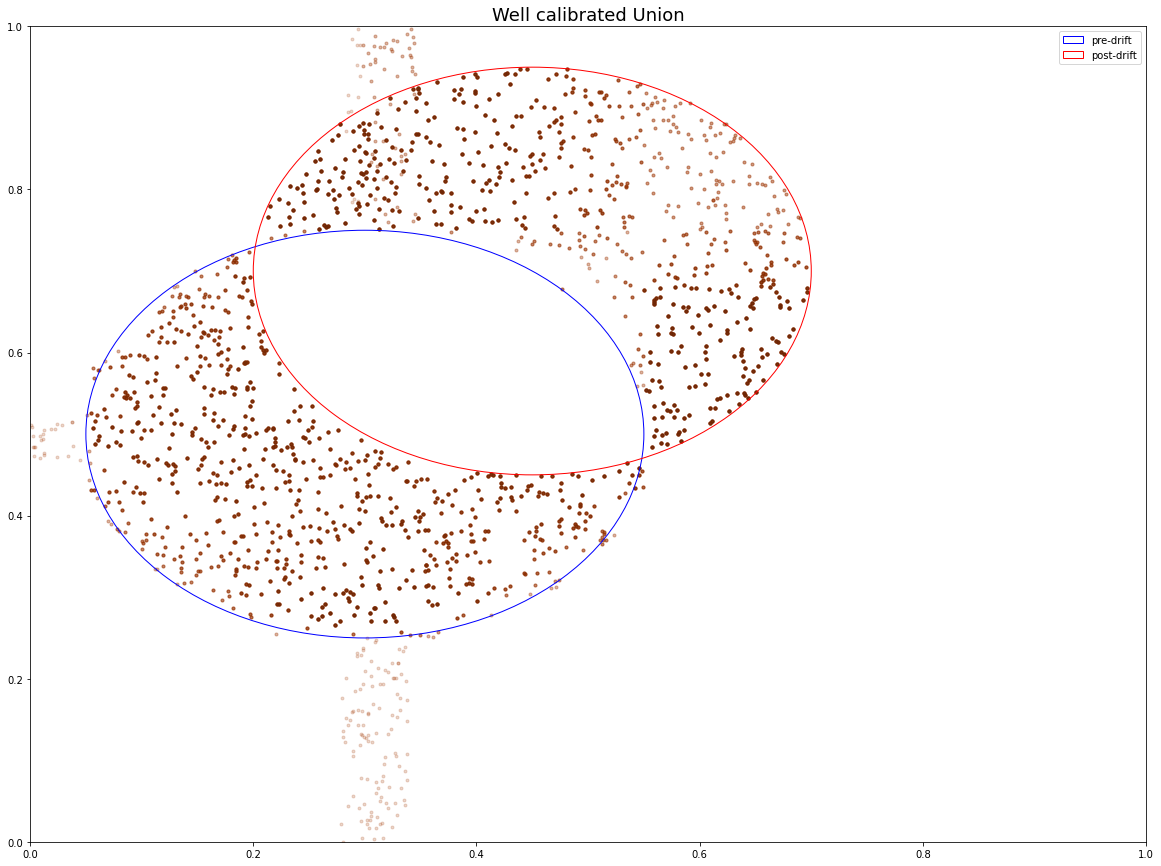

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [20,15])

cmap = matplotlib.cm.get_cmap('YlOrBr')#

for t in np.arange(0.85,0.99,0.01):#[0.85, 0.9, 0.99]:
#high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_ix = [i for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_iy = [i for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    pbms_i = np.union1d(pbm_ix,pbm_iy)
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    ax.scatter(pbms_x, pbms_y, marker = '.', alpha = 0.2, color = cmap(t))
    ax.set_title("Well calibrated Union", fontsize = 18)
    
ax.set_ylim(ymin = 0, ymax=1)
ax.set_xlim(xmin = 0, xmax=1)
circle1 = plt.Circle((0.3,0.5),0.25, color = 'b', fill = False, label="pre-drift")
circle2 = plt.Circle((0.45,0.7),0.25, color = 'r', fill = False, label="post-drift")
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.legend()
    
plt.show()

In [67]:
for t in [0.90]:#[0.1, 0.5, 0.75, 0.9, 0.99]:
#high threshold
    shap_thresh = np.quantile(shap_values, t)
    pbm_ix = [i for i,x in enumerate(shap_values[:,0]) if x > shap_thresh]
    pbm_iy = [i for i,x in enumerate(shap_values[:,1]) if x > shap_thresh]

    #pbms_i = pbm_iy
    #pbms_i = np.intersect1d(pbm_ix,pbm_iy)
    #pbms_i = pbm_ix
    pbms_i = np.union1d(pbm_ix,pbm_iy)
    
    pbms_x, pbms_y = X_explain.iloc[pbms_i].x, X_explain.iloc[pbms_i].y
    
    new_train = pd.DataFrame(columns = ["x","y","class"])
    new_train.loc[:,'x'] = pbms_x
    new_train.loc[:,'y'] = pbms_y

    
    explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
    shap_val_out = explainer.shap_values(new_train.drop(columns = ['class']))

#shap.force_plot(explainer.expected_value[0], shap_val_out[0])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [68]:
shap.initjs()

In [69]:
print("union")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

union


In [70]:
print("X")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

X


In [71]:
print("Y")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

Y


In [72]:
print("intersect")
shap.force_plot(explainer.expected_value[0], shap_val_out[0])

intersect


 #Agrandir vs retrain 
1 feature fait nimp mais pas impact
f p

# tableau avec problemes de chaque type de drift